In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
# !unzip Train_rev1.zip
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [3]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


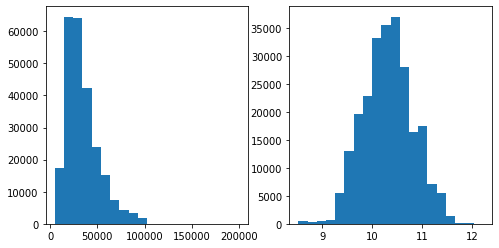

In [4]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [5]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
18779,67057369,CME08017 Teacher of Primary,Department: Community Services Closing Date: F...,Scotland,Scotland,part_time,permanent,ST MUNS PRIMARY SCHOOL,Teaching Jobs,"21,438 - 34,200",27819,jobs.guardian.co.uk,10.233510
186843,71679347,Analyst/Sales Forecast Manager,The Company Major manufacturer World wide Bra...,"Slough, Berkshire Berkshire South East",Slough,NaN,contract,Signet Resources.,Accounting & Finance Jobs,16 - 19 per hour,33600,totaljobs.com,10.422311
92603,69182025,Assistant General Manager St Albans New Opening,My client operates a small but growing group o...,"St. Albans, Hertfordshire, UK, Hertfordshire",St. Albans,NaN,NaN,ITK Recruitment,Hospitality & Catering Jobs,"From 23,000 to 28,000 per annum overtime paid ...",25500,jobs.catererandhotelkeeper.com,10.146473


In [6]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [7]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
for col in text_columns:
    data[col] = data[col].apply(lambda x: " ".join(tokenizer.tokenize(str(x).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

for col in text_columns:
    for line in data[col].values:
        token_counts.update(line.split(" "))

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


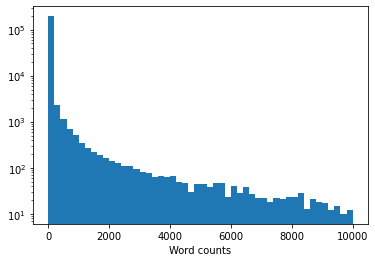

In [11]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [12]:
min_count = 10

tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [13]:
print("Vocabulary size:", len(tokens))

Vocabulary size: 34158


In [14]:
token_to_id = {t: i for i, t in enumerate(tokens)}#TODO<your code here>

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [19]:
from sklearn.feature_extraction import DictVectorizer

top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [21]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144])}


![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

In [23]:
import torch
import torch.nn as nn
import torch.functional as F

In [24]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.embedder = nn.Embedding(n_tokens, embedding_dim=hid_size)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1),
        )
        self.description_encoder = nn.Sequential(
            nn.Conv1d(hid_size, hid_size, kernel_size=2),
            nn.Dropout(p=0.25),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1),
        )
        self.categotical_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size * 2),
            nn.ReLU(),
            nn.Linear(hid_size * 2, hid_size * 2),
            nn.ReLU(),
        )

        self.final_predictor = nn.Sequential(
            nn.Linear(hid_size * 4, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, batch):
        title_embeddings = self.embedder(batch["Title"]).transpose(1,2)
        title_features = self.title_encoder(title_embeddings).squeeze()
        description_embeddings = self.embedder(batch["FullDescription"]).transpose(1,2)
        description_features = self.description_encoder(description_embeddings).squeeze()
        categorical_features = self.categotical_encoder(batch["Categorical"])
        features = torch.cat([title_features, description_features, categorical_features], 1)
        return self.final_predictor(features).squeeze()
        
        

In [25]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])

In [26]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break

### Model training


In [28]:
import tqdm

BATCH_SIZE = 512
EPOCHS = 5
DEVICE = torch.device('cuda')

In [29]:
from copy import deepcopy
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    m = deepcopy(model)
    model = m.to('cpu')
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.dot((batch_pred - batch[TARGET_COLUMN]), (batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [30]:
val_batch = make_batch(data_val.iloc[:1000], device=DEVICE)

In [31]:
model = SalaryPredictor().to(DEVICE)
criterion = nn.L1Loss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        model.train()
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if i % 100 == 99:
            model.eval()
            with torch.no_grad():
                pred = model(val_batch)
                val_loss = criterion(pred, val_batch[TARGET_COLUMN])
                print(f"val_loss: {val_loss}")
                print(f"train_loss: {loss}")
    print_metrics(model, data_val)

      

epoch: 0


/home/ivan/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


val_loss: 0.37800413370132446
train_loss: 0.40036439895629883
val_loss: 0.2829867899417877
train_loss: 0.28377005457878113
val_loss: 0.2521619200706482
train_loss: 0.2660430669784546

 results:
Mean square error: 0.10984
Mean absolute error: 0.24993
epoch: 1


val_loss: 0.27224498987197876
train_loss: 0.23682048916816711
val_loss: 0.2254098802804947
train_loss: 0.23151642084121704
val_loss: 0.24738538265228271
train_loss: 0.23373523354530334

 results:
Mean square error: 0.09960
Mean absolute error: 0.24163
epoch: 2


val_loss: 0.21592232584953308
train_loss: 0.24675893783569336
val_loss: 0.21301507949829102
train_loss: 0.22090475261211395
val_loss: 0.2151000201702118
train_loss: 0.21576370298862457

 results:
Mean square error: 0.08447
Mean absolute error: 0.21490
epoch: 3


val_loss: 0.22861649096012115
train_loss: 0.2261209636926651
val_loss: 0.20677118003368378
train_loss: 0.1982647180557251
val_loss: 0.20620928704738617
train_loss: 0.2159053087234497

 results:
Mean square error: 0.07935
Mean absolute error: 0.20728
epoch: 4


val_loss: 0.20298337936401367
train_loss: 0.20948061347007751
val_loss: 0.2277013212442398
train_loss: 0.1905142366886139
val_loss: 0.2240709662437439
train_loss: 0.2003752887248993

 results:
Mean square error: 0.08249
Mean absolute error: 0.21306
